In [63]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts

#### 1. Load the data

In [64]:
data_type = 'N3'

df = joblib.load(data_type + '_frequency_data.pkl')

folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
paths = joblib.load(folder + data_type + '_paths.pkl')

groups = pd.Series(paths['s_p_id'])
s_class_list = pd.Series(paths['s_class_list'])
y = s_class_list.map({'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3}) 

df['label'] = y

#### 2. Construct Dataframe that makes it easy to plot (calc mean and std of each freq feature)

In [65]:
freq_features = ['Delta', 'Theta', 'Low_Alpha', 'Alpha', 'High_Alpha', 'Sigma', 'Beta', 'Gamma', 'TotalAbsPow', 'Fast_ratio', 'Alpha_shift']
regions = constants.regions

In [66]:
# Format the data in a way that makes it easy to plot
cols_for_plotting = ['Region', 'Freq_Feature','Mean','Std', 'Class_label']
plotting_df_dict = {}
for col in cols_for_plotting:
    plotting_df_dict[col] = []

#Now fill up the plotting dict with data 
for label in np.unique(y):
    df_subset = df[df['label'] == label]
    df_mean_std = pd.concat( [ pd.DataFrame( df_subset.std(axis = 0) , columns = ['std']) , pd.DataFrame( df_subset.mean(axis = 0) , columns = ['mean']) ], axis = 1 )
    for freq_feature in freq_features:
        for region in regions:
            col = freq_feature + '_' + region
            mean_val = df_mean_std.loc[col, 'mean']
            std_val = df_mean_std.loc[col, 'std']
            #Populate the dict 
            plotting_df_dict['Region'].append(region)
            plotting_df_dict['Freq_Feature'].append(freq_feature)
            plotting_df_dict['Mean'].append(mean_val)
            plotting_df_dict['Std'].append(std_val)
            plotting_df_dict['Class_label'].append(label)

plotting_df = pd.DataFrame(plotting_df_dict)
plotting_df

,Region,Freq_Feature,Mean,Std,Class_label
0,Prefrontal,Delta,0.892100,0.040449,0
1,Frontal,Delta,0.834590,0.064097,0
2,Left Frontal,Delta,0.870061,0.047872,0
3,Right Frontal,Delta,0.862486,0.046792,0
4,Central,Delta,0.824737,0.058733,0
...,...,...,...,...,...
567,Right Temporal,Alpha_shift,8.564340,4.997228,3
568,Parietal,Alpha_shift,10.237591,5.346426,3
569,Left Parietal,Alpha_shift,9.204788,6.197560,3
570,Right Parietal,Alpha_shift,9.492298,6.559400,3


#### Create plots

<Figure size 640x480 with 0 Axes>

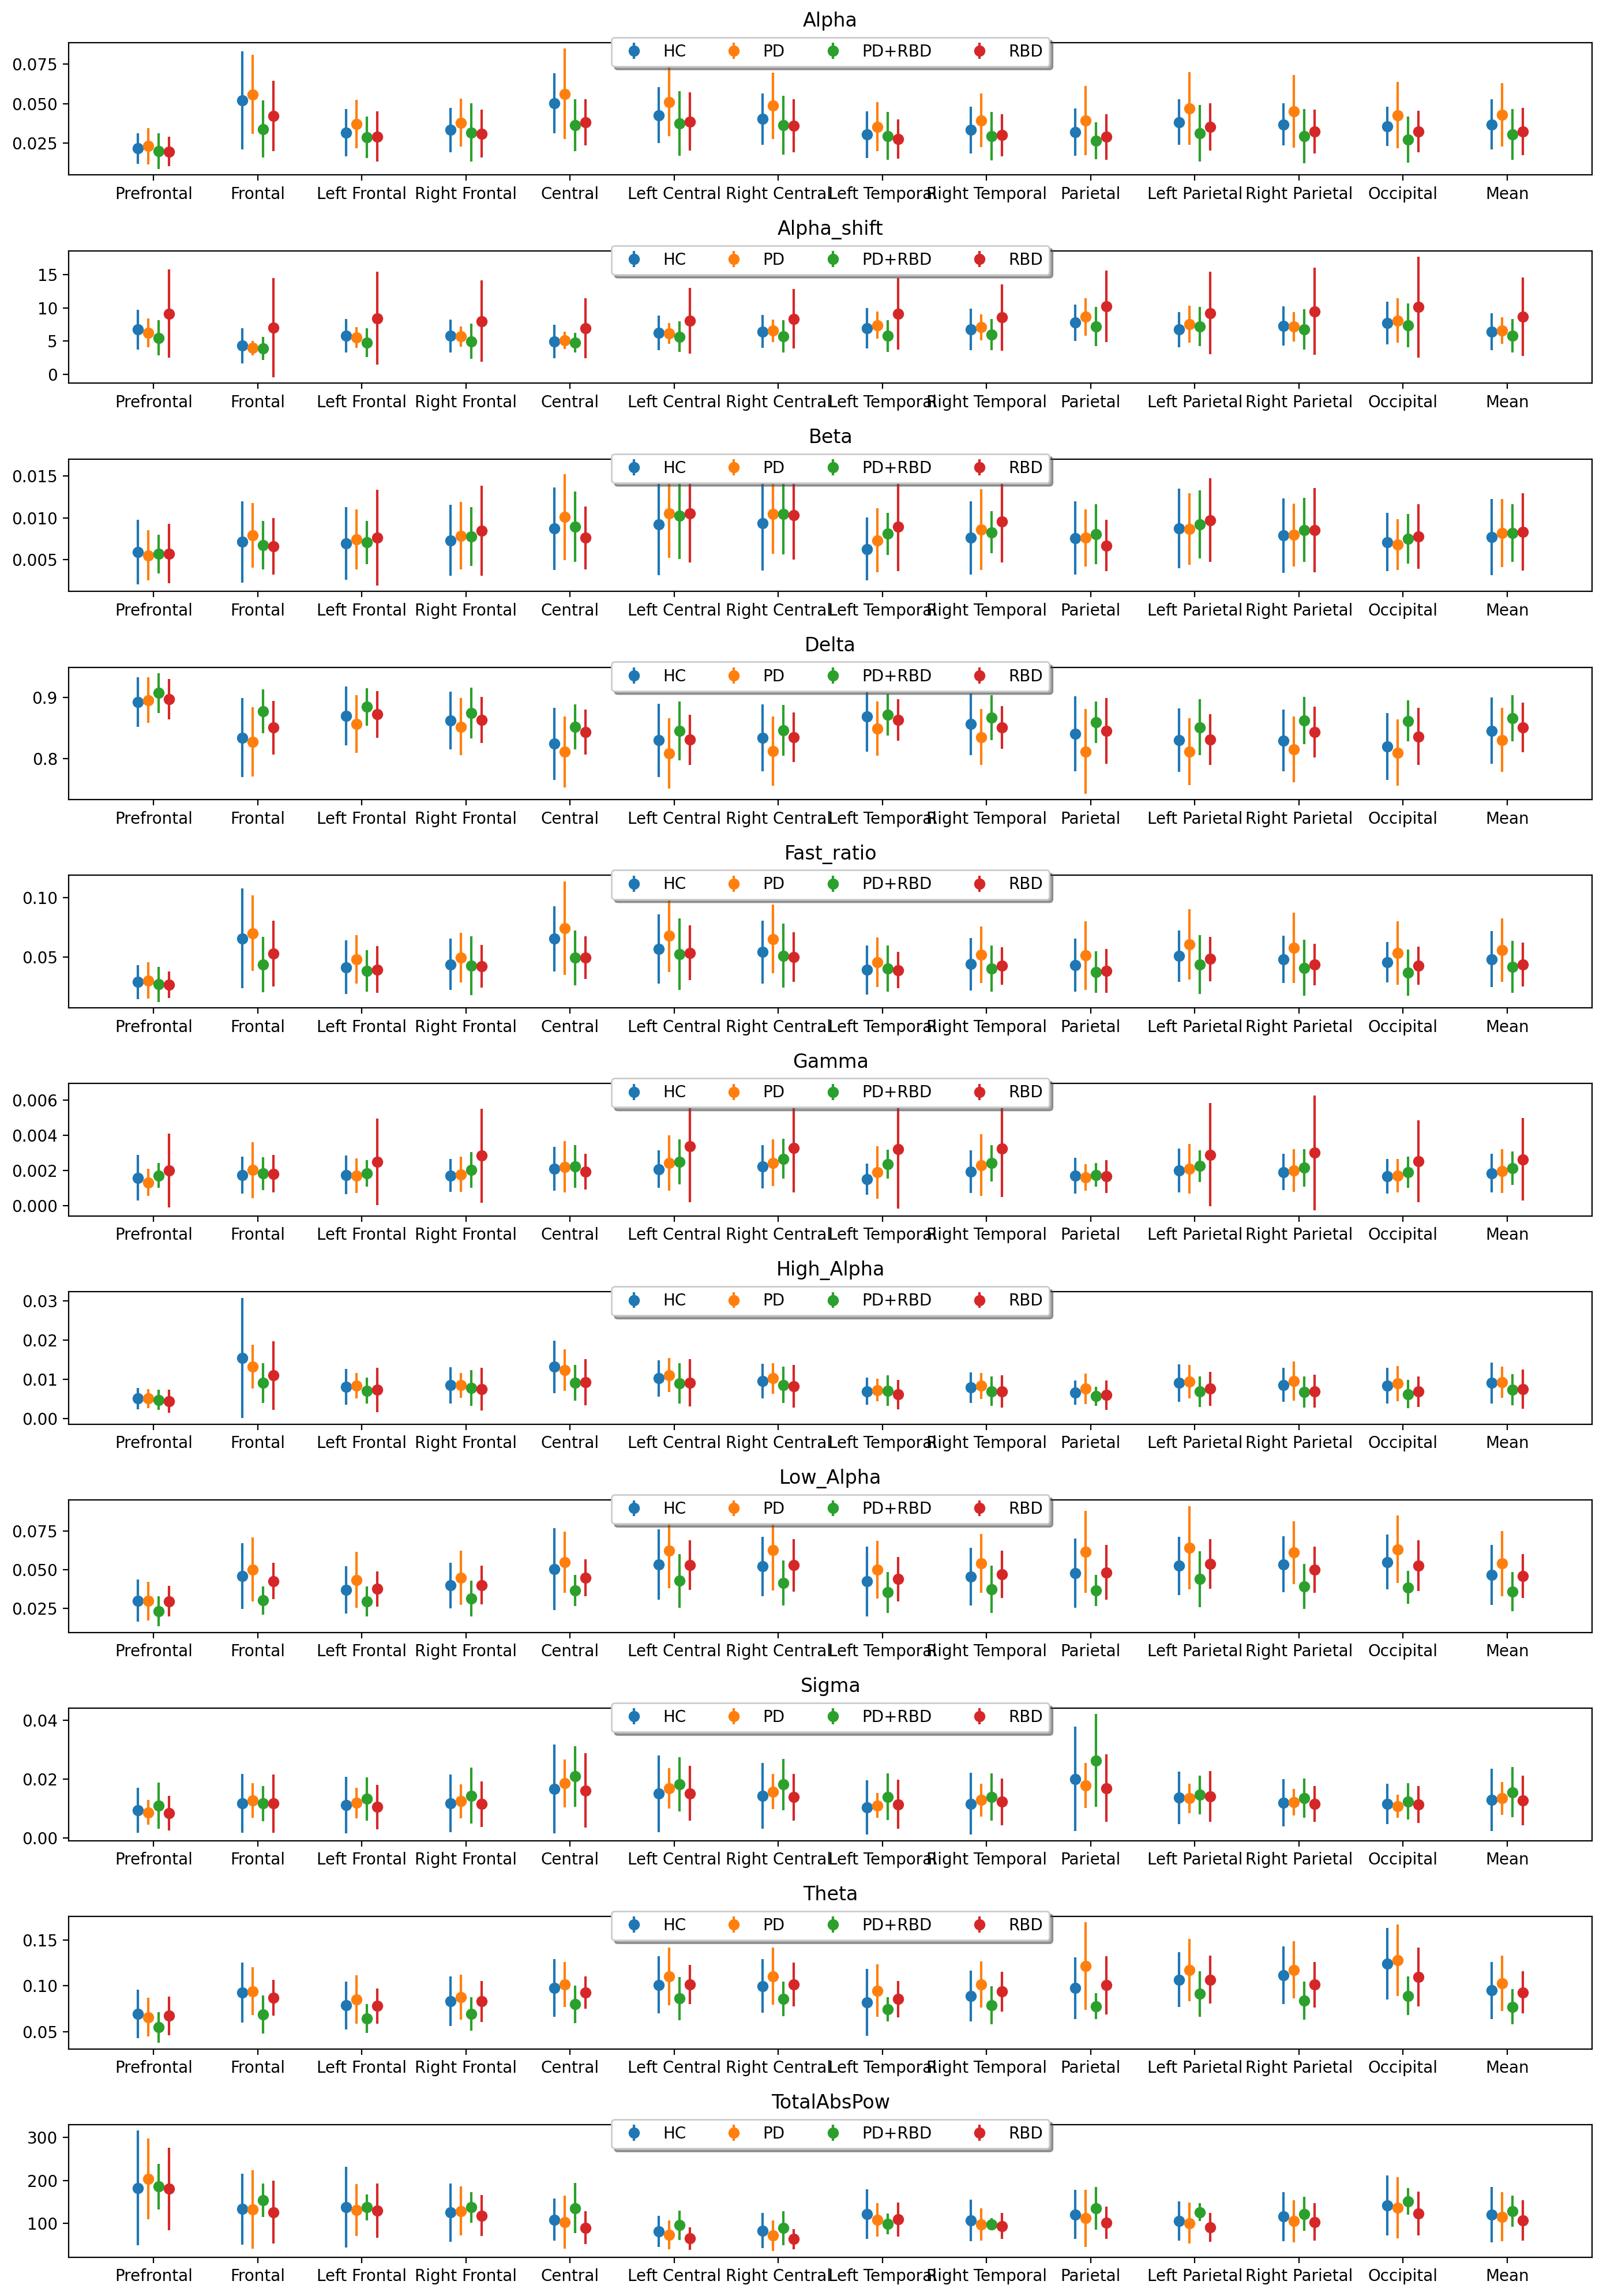

In [67]:
# dict to map numbers to classes
num_to_classes = {0: 'HC', 1: 'PD', 2: 'PD+RBD', 3: 'RBD'}

#initialise the figure object
fig = plt.figure()
fig = plt.figure(figsize=(14,20),dpi=200)

s = 0.1 #This is the horizontal spacing between classes

for num, col in enumerate( np.unique( plotting_df.Freq_Feature.values )  ) :
    ax = fig.add_subplot(11,1,num+1)
    spac_num = -1.5
    
    plt.title(col, pad = 10)
    
    for class_num in [0,1,2,3]:
        class_df = plotting_df[plotting_df['Class_label'] == class_num]
        feat_class_df = class_df[class_df['Freq_Feature'] == col]
        mean_mean = feat_class_df.iloc[:,2:].mean()['Mean']
        mean_std = feat_class_df.iloc[:,2:].mean()['Std']
        plt.errorbar(np.arange(len(feat_class_df.Region.values) + 1 ) + 0.5 + (s*spac_num) ,  list(feat_class_df.Mean.values) + [mean_mean] , label =  num_to_classes[class_num] , yerr = list(feat_class_df.Std.values) + [mean_std] , fmt='o')
        spac_num +=1
        
    plt.xticks(np.arange( len(feat_class_df.Region.values) +1 )+0.5, list(feat_class_df.Region.values) + ['Mean'] )
    plt.tight_layout()
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=4, fancybox=True, shadow=True)
    
    # plt.legend()

plt.savefig(data_type + '.png')
